In [1]:
# Diffusersによる事前学習済みDDPMからの画像生成

In [2]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.7 MB/s eta 0:00:00


In [3]:
# ログ表示、画像表示等
import tqdm
import PIL.Image
import numpy as np
import torch
from diffusers import (DDPMPipeline,
                       UNet2DModel,
                       DDPMScheduler)

In [4]:
# 事前学習モデルの読み込み、画像生成
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
# colabの場合、ランタイムをGPUインスタンスにしてから以下のコードを実行しないとエラーになる。
image_pipe.to("cuda")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.16.1",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [5]:
# 事前学習モデルから画像を作成
images = image_pipe().images

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
images

[<PIL.Image.Image image mode=RGB size=256x256 at 0x7FEA3042E650>]

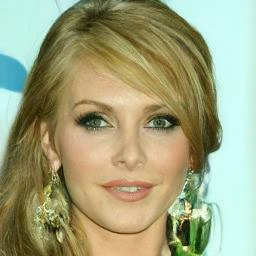

In [12]:
images[0]

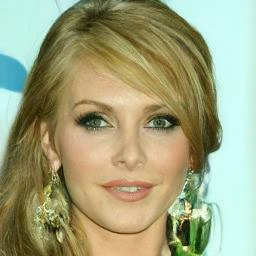

In [10]:
images[-1]

In [7]:
# 事前学習済みモデルを使って手動での画像生成
repo_id = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(repo_id)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [13]:
# unetの中身を確認
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [15]:
# 学習時の設定を確認
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('act_fn', 'silu'),
            ('attention_head_dim', None),
            ('norm_num_groups', 32),
            ('norm_eps', 

In [16]:
from os import sched_get_priority_max
# スケジューラ（学習時の初期ノイズの大きさなど）を取得
scheduler = DDPMScheduler.from_config(repo_id)

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [17]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.1.1')])

In [18]:
# 画像表示用の関数
# 引数のsampleは画像のPytorch配列
def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    # 0~1の整数値を0~255の範囲になるように変換
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)
    # 画像の配列をPIL形式に変換
    image_pil = PIL.Image.fromarray(image_processed[0])
    # タイムステップの表示
    display(f"Image at step {i}")
    display(image_pil)

In [19]:
scheduler.set_timesteps(num_inference_steps=1000)

 10%|▉         | 99/1000 [00:12<01:50,  8.13it/s]

'Image at step 100'

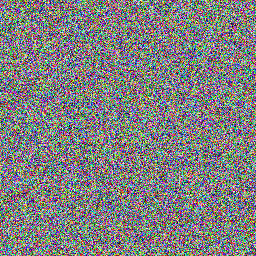

 20%|█▉        | 199/1000 [00:24<01:37,  8.25it/s]

'Image at step 200'

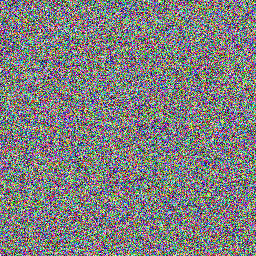

 30%|██▉       | 299/1000 [00:36<01:23,  8.42it/s]

'Image at step 300'

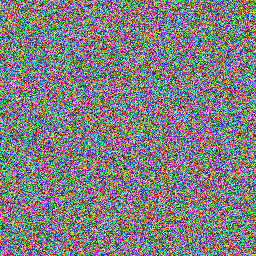

 40%|███▉      | 399/1000 [00:48<01:11,  8.42it/s]

'Image at step 400'

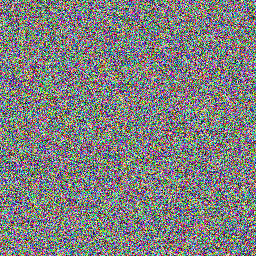

 50%|████▉     | 499/1000 [01:00<00:59,  8.45it/s]

'Image at step 500'

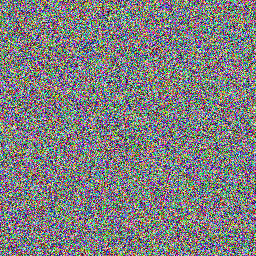

 60%|█████▉    | 599/1000 [01:12<00:47,  8.36it/s]

'Image at step 600'

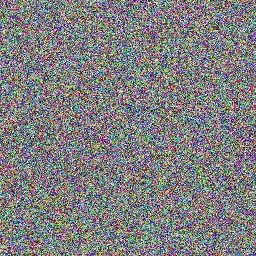

 70%|██████▉   | 699/1000 [01:23<00:36,  8.35it/s]

'Image at step 700'

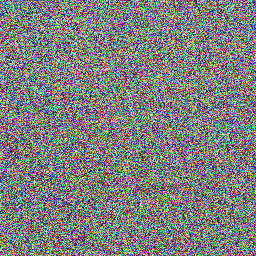

 80%|███████▉  | 799/1000 [01:35<00:24,  8.28it/s]

'Image at step 800'

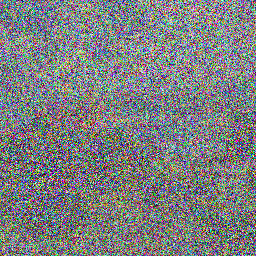

 90%|████████▉ | 899/1000 [01:47<00:12,  8.34it/s]

'Image at step 900'

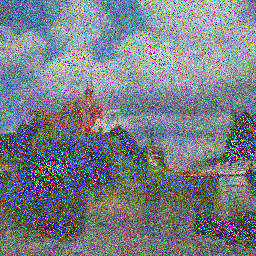

100%|█████████▉| 999/1000 [02:00<00:00,  8.38it/s]

'Image at step 1000'

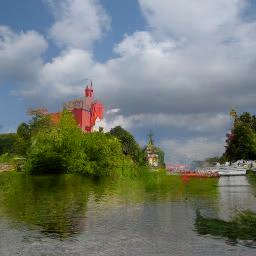

100%|██████████| 1000/1000 [02:00<00:00,  8.31it/s]


In [21]:
torch.manual_seed(0)
# 最初の標準正規分布に従う乱数の生成
noisy_sample = torch.randn(
    1, #データ数
    model.config.in_channels, # チャンネル数
    model.config.sample_size, # 縦(=256)
    model.config.sample_size # 横（=256）
)

# 事前学習済みU-NetをGPUに転送
model.to("cuda")

# 乱数をGPUに転送
noisy_sample = noisy_sample.to("cuda")

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    with torch.no_grad():
        residual = model(sample,
                         t
                         ).sample # 差分を取得
    
    # ノイズ除去後の画像を取得
    sample = scheduler.step(residual, t, sample).prev_sample

    if (i + 1) % 100 == 0:
        display_sample(sample, i + 1)
